# I. Introduction

* **By** Saif Khattak (s5khatta)

* **Based on the Paper**:
    * *Title*: An Efficient Mixed Noise Removal Technique from Gray Scale Images using Noisy Pixel Modification Technique
    * *Authors*: Jayasree. M, N.K. Narayanan

In [9]:
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, interact_manual, fixed, IntSlider, Checkbox
from IPython.display import display
import ipywidgets as widgets
import zipfile
import time
import os
import pandas as pd
import random
import seaborn as sns

# II. Problem Formulation

The authors note that a common type of noise in digital images is 'mixed noise'. This is noise that is both corrupted by 'salt & pepper' (or 'impulse') noise as well as Gaussian noise. Salt & pepper noise is that which either places a 0 or a 255 (max) value at a certain percentage of pixels. Gaussian noise adds a random value to each pixel, following a gaussian probability density function. These noise distributions are common artifacts of camera sensors or channel transmission. Existing algorithms are either inneficient, or degrade fine features such as edges in the original image due to the fact that they also modify noise-free pixels.

# III. Proposed Solution

The authors propose a fuzzy noise-detection algorithm with median replacement to denoise images affected by mixed, gaussian, or impulse noise while preserving details and edges. The method is quite simple, and takes the form of the following 3 steps. For each pixel $x_{i,j}$ perform the following. Note that T1 and T2 are arbitrary constants within the ranges $[10, 20]$ and $[22, 32]$ respectively:

1. compute $M = max(|x_{i,j} - W|)$ and $m = median\{W\}$ where $W$ is a 3x3 window of the original image centered on $x_{i, j}$
2. compute $f = \frac{M - T_1}{T_2 - T_1}$, cutting off values greater than 1 and less than 0 ($f \in [0, 1]$)
3. set the denoised pixel $y_{i,j} = (1 - f) * x_{i, j} + f * m$

# IV. Data Sources

The authors set T1 = 15 and T2 = 25 for their testing, and we will do the same. For the images, we will use the Berkeley Segmentation Dataset ([BSDS300](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/)). We will manually add noise to these images, as it is important that the noise be added *after* compression (e.g. to simulate the effect of channel transmission), otherwise the method does not work very well.

# V. Algorithm Specification
Here we will show the algorithm presented in the paper, along with a demonstration of its results, and some observations.

## Step 1 - Loading the Image

First we load the image and convert it to grayscale. We can then add mixed noise if we want to compare the denoised result to the original, noise-free image.

We define gaussian noise by the following:

$$ y_{i, j} = x_{i, j} + X $$
 
Where $X$ is a random variable distributed normally with mean 0 and standard deviation u% (default 5%) of the image's standard deviation.

After adding gaussian noise, we set v% (default 5%) of pixels to 0 or 255 for the impulse noise, then clip all pixel values to $[0, 255]$ for the final noisy image result.

In [3]:
# allows us to add mixed noise to an image
def add_noise(img, impulse, gaussian):
    std = np.sqrt(gaussian) * np.std(img)
    gaussian = np.random.normal(0, std, img.shape)

    # add gaussian noise
    noisy_img = img + gaussian

    # The probability of a pixel to be affected by the impulse noise is given by the impulse parameter.
    impulsenoise = np.random.binomial(1, impulse, img.shape)
    pixels_impulse = np.sum(impulsenoise)

    # now apply the impulse noise: randomly choose affected pixels to be zeroed out or set to 1
    noisy_img[impulsenoise == 1] = np.random.choice([0, 255], size=pixels_impulse)

    # clip values to 0,255 to ensure no overflow
    noisy_img = np.clip(noisy_img, 0, 255)
    noisy_img_int = noisy_img.astype(np.uint8)

    return noisy_img_int

# plots a noisy image compared to the original as well as the histograms
def plot_with_noise(impulse, gaussian):
    global im_noisy

    # add impulse noise and gaussian noise to the image
    im_noisy = add_noise(im_original, impulse/ 100.0, gaussian/ 100.0)
    
    # plot the original and noisy side by side
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(im_original, cmap='gray')
    plt.title('Original Image (test/{}.jpg)'.format(demo_id))
    plt.subplot(2, 2, 2)
    plt.imshow(im_noisy, cmap='gray')
    plt.title('Noisy Image (s&p = {}%, gauss = {}%)'.format(impulse, gaussian))
    # plot a histogram of pixel values before and after noise
    plt.subplot(2, 2, 3)
    plt.hist(im_original.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
    plt.title('Histogram of Original Image')
    plt.subplot(2, 2, 4)
    plt.hist(im_noisy.ravel(), bins=256, range=(0, 255), fc='k', ec='k')
    plt.title('Histogram of Noisy Image')
    plt.show()

# unzip BSDS
with zipfile.ZipFile('BSDS300.zip', 'r') as zip_ref:
    zip_ref.extractall('images/')

BSDS_Path = './images/BSDS300/images/test'
BSDS_ids = open('./images/BSDS300/iids_test.txt', 'r').readlines()

# load a random image from the dataset
demo_id = int(np.random.choice(BSDS_ids).strip())
demo_image = BSDS_Path + '/' + str(demo_id) + '.jpg'
im_original = np.array(Image.open(demo_image).convert('L'))

# add noise to im_original
im_noisy = im_original.copy()

interact(plot_with_noise,
    impulse=IntSlider(min=0, max=100, step=1, value=5),
    gaussian=IntSlider(min=0, max=100, step=1, value=5));

You should consider upgrading via the 'g:\code\vue\portfolio-site\venv\scripts\python.exe -m pip install --upgrade pip' command.


  Using cached matplotlib-3.5.1-cp38-cp38-win_amd64.whl (7.2 MB)
  Using cached kiwisolver-1.3.2-cp38-cp38-win_amd64.whl (52 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)


interactive(children=(IntSlider(value=5, description='impulse'), IntSlider(value=5, description='gaussian'), O…

## Step 2 - Filtering the Image

We can now apply the filtering technique to this grayscale image. We iterate over the whole image, creating the 3x3 W window, and computing the differences **M(i,j)**, membership function **f(i,j)**, and the median difference **m(i,j)**

In [4]:
# The main filtering function from the paper
def denoise_slow(im_gray, t1, t2):
    l1 = im_gray.shape[0]
    l2 = im_gray.shape[1]
    print("image size: {}x{}".format(l1, l2))
    f = np.zeros([l1, l2])
    m = np.zeros([l1, l2])
    M = np.zeros([l1, l2])
    y = np.zeros([l1, l2])

    # iterate over the whole image
    for i in range(0, l1):
        for j in range(0, l2):
            # 3x3 window centered on pixel (i,j)
            W = im_gray[max(i-1,0):min(i+2, l1-1), max(j-1,0):min(j+2,l2-1)].astype(float)
            # compute the max absolute difference between the pixel and the window
            M[i][j] = np.abs(W - im_gray[i,j]).max()
            # compute the median of the window
            m[i][j] = np.median(W)
            # compute the membership function, cutting off the values above T1 and below T2
            f[i][j] = min(1, max(float(M[i][j] - t1) / float(t2 - t1), 0))
            # now apply the denoising to this pixel
            y[i][j] = (1 - f[i][j]) * float(im_gray[i,j]) + f[i][j] * m[i][j]

    # return the denoised image as well as the noise map (membership function f) for analysis
    return y, f

# much faster than the original denoise function, however edge artifacts are produced
# which results in a ~2dB SNR reduction. It is also generalized to any window size
def denoise_optimized(im_gray, t1, t2, window_size=3):
    l1 = im_gray.shape[0]
    l2 = im_gray.shape[1]
    # create 8 images of the same size as the original image
    W = np.zeros([l1, l2, window_size**2 - 1]).astype(float)
    mid_window = int((window_size-1) / 2)

    # pad the image with its edge values to mitigate edge effects
    im_gray_padded = np.pad(im_gray, mid_window, 'edge')

    # e.g. for a 3x3 window, the indices of the pixels in the window are:
    #   0  1  2 
    #   3     4
    #   5  6  7
    n = 0
    for i in range(-mid_window, mid_window+1):
        for j in range(-mid_window, mid_window+1):
            if i == j and i == 0: continue

            # roll the image by i,j, cutting off the beginning and end values to fit it properly
            W[:,:,n] = np.roll(
                np.roll(
                    im_gray_padded,
                    i,
                    axis=0),
                j,
                axis=1)[mid_window:-mid_window,mid_window:-mid_window]
            n += 1

    # compute the max absolute difference between the pixel and the window
    M = np.abs(W - im_gray[:,:,np.newaxis]).max(2)
    m = np.median(W, 2)
    f = np.clip((M - t1) / (t2 - t1), 0, 1)
    y = (1 - f) * im_gray + f * m

    return y, f

# generic denoise function that can be used for any window size and allows for the optimized algorithm
def denoise(im_gray, t1, t2, algorithm='slow', window_size=3):
    if algorithm == 'slow':
        return denoise_slow(im_gray, t1, t2)
    elif algorithm == 'optimized':
        return denoise_optimized(im_gray, t1, t2, window_size)
    else:
        raise ValueError('algorithm must be either slow or optimized')


# PSNR: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio
# this tells us how close the denoised image is to the original
def compute_psnr(original, denoised, include_edge=True):
    l1, l2 = original.shape if include_edge else original[1:-1,1:-1].shape
    if (original.shape != denoised.shape):
        print("Error: original and denoised image have different sizes")
        return 0
    else:
        orig = original.astype(float) if include_edge else original[1:-1,1:-1].astype(float)
        den = denoised.astype(float) if include_edge else denoised[1:-1,1:-1].astype(float)

        mse = np.sum(np.square(orig - den)) / (l1 * l2)
        PSNR = 10*np.log10(255**2 / mse)
        return PSNR

denoised, noise_map, T1, T2 = 0, 0, 0, 0

def compute_result(im_gray, T_1, T_2, Optimized, Window):
    global T1, T2, denoised, noise_map

    T1 = T_1
    T2 = T_2
    algo = 'slow' if not Optimized else 'optimized'

    # denoise the image using the default method
    t_start = time.time()
    denoised, noise_map = denoise(im_gray, T1, T2, algo, Window)
    t_end = time.time()
    print("Denoising took {:0.2f} seconds".format(t_end - t_start))

    # compute the psnr for a quantitative measure of quality
    psnr = compute_psnr(im_original, denoised, include_edge=True)

    plt.figure(figsize=(20, 20))
    plt.subplot(1,3,1)
    plt.imshow(im_original, cmap='gray')
    plt.title('Original Image (test/{}.jpg)'.format(demo_id))

    plt.subplot(1,3,2)
    plt.imshow(im_gray, cmap='gray')
    plt.title('Noisy Image')

    plt.subplot(1,3,3)
    plt.imshow(denoised, cmap='gray')
    plt.title('Denoised image\nT1={}, T2={}\nPSNR={:.2f}dB'.format(T1, T2,psnr))
    
    plt.show()

# allow the amount of noise to be controlled by sliders
window_size_slider = IntSlider(min=3, max=21, step=2, value=3, description='Window Size:')
optim_button = Checkbox(
        value=False,
        description='Optimized Algorithm',
        description_tooltip='Use the optimized algorithm (faster, but less accurate)')
window_size_slider.layout.visibility = 'hidden'

# make window_size_slider invisible when optim_button is checked
def update_slider(change):
     window_size_slider.layout.visibility = 'hidden' if change['old'] else 'visible'

optim_button.observe(update_slider, names='value')

# allow the user to change T1 and T2
w = interact_manual(compute_result,
    im_gray=fixed(im_noisy),
    T_1=IntSlider(min=10,max=20,value=15),
    T_2=IntSlider(min=22,max=32,value=25),
    Optimized=optim_button,
    Window=window_size_slider);

w.widget.children[4].description = 'Apply Noise Filter';

interactive(children=(IntSlider(value=15, description='T_1', max=20, min=10), IntSlider(value=25, description=…

# VI. Analysing the Results

The histogram of f shows us what fraction of pixels are determined to be noisy (a higher value means the pixel is more noisy, up to 100%). We can also show this spatially to see where the noise is detected. For example, using the image from the example above, we can do:

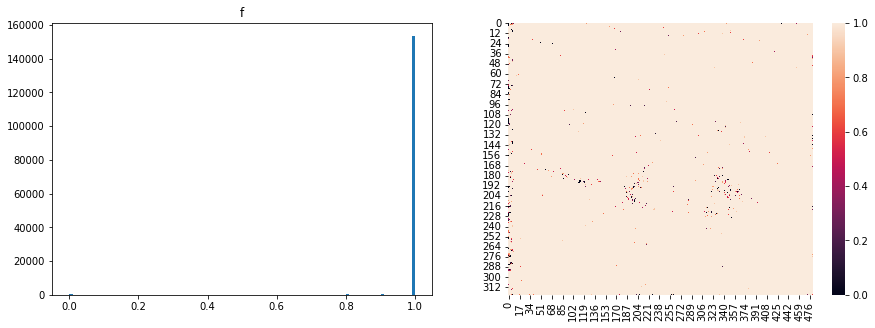

In [6]:
# plot a normalized histogram of f
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(noise_map.flatten(), bins=100, range=(0,1))
plt.title('f')

# show a heatmap of noise_map
plt.subplot(1, 2, 2)
sns.heatmap(noise_map)
plt.show()

## 1. Varying impulse noise
We can now use the same method as above for a number of images, and see if our results match those of the paper. In the paper, we find the following information (Fig. 3)

| Impulse (%)   | Gaussian (%)  | PSNR  |
| -------       | --------      | ----  |
| 5             | 5             | 45.94 |
| 11            | 5             | 45.83 |
| 17            | 5             | 45.58 |
| 23            | 5             | 45.21 |

We will pick a certain number of images, and compute the PSNR over the impulse noise range of [0, 20]%. This will take quite some time.

In [7]:
cols = ['red', 'green', 'blue', 'purple', 'hotpink',
        'chocolate', 'black', 'olive', 'skyblue', 'crimson']

# now lets denoise it over various values of impulsenoise
def compute_results(N):
    psnrs = []

    # pick N random images from BSDS
    images = [BSDS_Path + '/' + x for x in np.random.choice(os.listdir(BSDS_Path), N)]
    
    # iterate over the images
    result_data_per_image = {}
    for image in images:
        # load the image
        im_original = np.array(Image.open(image).convert('L'))
        
        result_data_per_image[image] = []

        # denoise it (use the fast algorithm otherwise this is too slow)
        for i in range(5, 20, 2):
            noisy_image = add_noise(im_original, i/100.0, 0.05)
            denoised, noise_map = denoise(noisy_image, 15, 25, algorithm='optimized')
            psnr = compute_psnr(im_original, denoised, include_edge=False)

            result_data_per_image[image].append(
                (i, im_original, noisy_image, denoised, psnr, noise_map))


    # for each image, plot the psnrs as a function of the noise level
    plt.figure(figsize=(15, 15))
    plt.xlabel('Noise level (S&P %)')
    plt.ylabel('PSNR (dB)')

    psnr_stats = {}
    for i, image in enumerate(result_data_per_image):
        psnrs = [x[4] for x in result_data_per_image[image]]
        noise = [x[0] for x in result_data_per_image[image]]
        psnr_stats[image] = (np.mean(psnrs), np.std(psnrs))

        # scatter plot of (noise, psnrs) labeled with this image overlaid
        col = cols[i] if i < len(cols) else (
            random.random(),
            random.random(),
            random.random())

        plt.scatter(noise, psnrs, label=image, color=col)


    plt.grid(True)
    plt.legend()
    plt.show()

    # now make a table of the mean and standard deviation of the psnrs,
    # with the rows being the images
    print(pd.DataFrame(psnr_stats, index=['mean', 'std']))
    # print out the average std deviation
    print('average standard deviation: {} (max {})'.format(
        np.mean([x[1] for x in psnr_stats.values()]),
        max([x[1] for x in psnr_stats.values()])))
   

w = interact_manual(compute_results, N=IntSlider(min=1, max=50, step=1, value=1));
w.widget.children[1].description = 'Run Process';

interactive(children=(IntSlider(value=1, description='N', max=50, min=1), Button(description='Run Interact', s…

we thus conclude that the PSNR is relatively stable over the impulse noise range, however this (and the mean PSNR value) is highly dependent on the exact image.

## 2. Varying Window Size

We can also try to see what a larger window would do when the impulse noise is held constant. This is not explored in the original paper, however extending our algorithm to do so is not difficult.

In [34]:
def compute_results(N):
    psnrs = []

    # pick N random images from BSDS
    images = [BSDS_Path + '/' + x for x in np.random.choice(os.listdir(BSDS_Path), N)]

    # iterate over the images
    result_data_per_image = {}
    for image in images:
        # load the image
        im_original = np.array(Image.open(image).convert('L'))
        
        result_data_per_image[image] = []

        # denoise it (use the fast algorithm otherwise this is too slow)
        for i in range(3, 22, 2):
            noisy_image = add_noise(im_original, i/100.0, 0.05)
            denoised, noise_map = denoise(noisy_image, 15, 25, algorithm='optimized', window_size=i)
            psnr = compute_psnr(im_original, denoised, include_edge=False)

            result_data_per_image[image].append(
                (i, im_original, noisy_image, denoised, psnr, noise_map))


    # for each image, plot the psnrs as a function of the noise level
    plt.figure(figsize=(15, 15))
    plt.xlabel('Window size (pixels)')
    plt.ylabel('PSNR (dB)')

    psnr_stats = {}
    for i, image in enumerate(result_data_per_image):
        psnrs = [x[4] for x in result_data_per_image[image]]
        noise = [x[0] for x in result_data_per_image[image]]
        psnr_stats[image] = (np.mean(psnrs), np.std(psnrs))

        # scatter plot of (noise, psnrs) labeled with this image overlaid
        col = cols[i] if i < len(cols) else (
            random.random(),
            random.random(),
            random.random())

        plt.scatter(noise, psnrs, label=image, color=col)


    plt.grid(True)
    plt.legend()
    plt.show()

w = interact_manual(compute_results, N=IntSlider(min=1, max=50, step=1, value=1));
w.widget.children[1].description = 'Run Process'

interactive(children=(IntSlider(value=1, description='N', max=50, min=1), Button(description='Run Interact', s…

clearly, for images like those in the BSDS with noise applied directly before processing, there is a dramatic drop-off in image quality as the window size is increased. This is likely due to the blurring effect of the median filtering, which may be a positive if the image was affected by lossy compression. Given the authors explicitly target images affected by mixed noise through channel transmission (and not compression), the window size of 3 seems to be optimal from an empirical standpoint.

# VII. Analysis and Conclusions

Overall, we find that we are somewhat able to reproduce the results reported in the original paper. Namely, the PSNR is roughly constant (typical max $\sigma^2 ~ 2$) over the impulse noise range of $[5, 23]$. We are unable to reproduce the exact value of ~45.9dB seen in the original paper for all images, as through some experimentation on the BSDS dataset the exact PSNR (as well as the $\sigma^2$ over the impulse noise range) we get heavily depends on the image given - this fact should be evident from the previous section. For some images, we see as low a value as 16dB while for others we are indeed able to get values in the 45-50dB range. We are also able to see that the algorithm does in fact preserve fine details: in the noisy map histogram we can see lower values near edges, indicating that the algorithm correctly identifies these as less noisy pixels, and thus does not modify them too much.  

One point of divergence between our results and the original paper is the precise definition of gaussian noise. The authors do not state what exactly 5 percent gaussian noise means, and may be referring to gaussian noise with standard deviation as a percentage of 255, rather than as a percentage of the image's standard deviation (as we assumed). In developing this report, we also found that a drawback of this algorithm is that applying any sort of compression to the image *after* the noise is applied results in a marked decrease in resulting PSNR. We suspect this is because of the small window size (3x3) used to compute the membership function $f_{i,j}$. If the algorithm were to be generalized to a larger window size we may find this algorithm to be resilient to compression as well (although without compression, we do find a 3x3 window size to be optimal). We also find that, as implemented in this notebook, the exact algorithm is quite slow on relatively small images. However, due to the parallel nature of the algorithm as well as its simplicity, it is likely not difficult to make a more efficient implementation. We have written one such implementation, which suffers from edge effects and thus a PSNR reduction of about 1dB. We use this algorithm for the PSNR trend test since this small difference does not matter as it is constant and we are only looking at a trend over a range of impulse noise values.

# VIII. Required Files

The demo above uses the BSDS dataset. A zipped copy is included in the submission, and will be unzipped by the first cell into `images`